In [21]:
# Imports
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

tensorflow : 2.3.0
matplotlib : 3.3.1
sys        : 3.8.10 (default, Jun  2 2021, 10:49:15) 
[GCC 9.4.0]
numpy      : 1.18.5
torch      : 1.6.0
torchvision: 0.7.0



In [4]:
# Verifica se a plataforma CUDA está disponível
train_on_gpu = torch.cuda.is_available()

In [5]:
# Mensagem para o usuário 
if not train_on_gpu:
    print('plataform CUDA não está disponível. O treinamento seŕa realizado com a CPU')
else:
    print('Plataforma CUDA está disponível! o treinamento será realizado com a GPU')

plataform CUDA não está disponível. O treinamento seŕa realizado com a CPU


In [7]:
# Lista todos os dispositivos disponiveis
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13368565467551579184
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11319014242753128793
physical_device_desc: "device: XLA_CPU device"
]


2021-08-16 18:21:13.045603: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-16 18:21:13.080361: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 1800000000 Hz
2021-08-16 18:21:13.081076: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7a2b630 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-08-16 18:21:13.081114: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-08-16 18:21:13.085038: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-08-16 18:21:13.112321: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] fai

In [9]:
import tensorflow as tf
print("Número Disponível de GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))

Número Disponível de GPUs:  0


## Carregando o Dataset

http://pytorch.org/docs/stable/torchvision/datasets.html

O download pode demorar um minuto. Carregamos os dados de treinamento e teste, dividimos os dados de treinamento em um conjunto de treinamento e validação e, em seguida, criamos DataLoaders para cada um desses conjuntos de dados.

Dataset usado: https://www.cs.toronto.edu/~kriz/cifar.html


In [22]:
# Função que converte os dados em um tensor normalizado
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [23]:
# Download dos dados de treino
dataTrain = datasets.CIFAR10('dados',
                            train=True,
                            download=True,
                            transform=transform)

100.0%

Extracting dados/cifar-10-python.tar.gz to dados


## Preparando os Data Loaders

In [24]:
dataTest = datasets.CIFAR10('dados',
                            train=False,
                            download=True,
                            transform=transform)

Files already downloaded and verified


In [25]:
# Dados de treino
dataTrain

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: dados
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [26]:
# Dados de teste
dataTest

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: dados
    Split: Test
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [27]:
# Número de amostras de treino
numTraniSample = len(dataTrain)
numTraniSample

50000

In [28]:
# Criamos um índice e o tornamos randômico 
indices = list(range(numTraniSample))
np.random.shuffle(indices)

In [29]:
# Percentual dos dados de treino que usaremos no dataset de validação
validSize =0.2

In [30]:
# Agora fazemos o split para os dados de treino e validação
split = int(np.floor(validSize*numTraniSample))
idxTrain, idxValid = indices[split:], indices[:split]

In [35]:
# Definimos as amostras de treino
trainSamples = SubsetRandomSampler(idxTrain)

In [36]:
# Definimos as amostras de validação
validSamples = SubsetRandomSampler(idxValid)

In [37]:
# Número de subprocessos para carregar os dados
numWorkers =0


In [33]:
# Número de amostras por batch
batchSize = 20

In [38]:
# Data Loader de dados de treino
trainLoader=torch.utils.data.DataLoader(dataTrain,
                                        batch_size=batchSize,
                                        sampler=trainSamples,
                                        num_workers =numWorkers)

In [39]:
# Data loader dados de validação
validLoader= torch.utils.data.DataLoader(dataTrain,
                                        batch_size=batchSize,
                                        sampler=validSamples,
                                        num_workers=numWorkers)

In [40]:
# Data loader de dados de teste
testLoader=torch.utils.data.DataLoader(dataTest,
                                        batch_size=batchSize,
                                        num_workers=numWorkers)

In [41]:
# Lista de classes das imagens
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [42]:
# Função para desnormalização das imagens
def imshow(img):
    # Desfaz a normalização 
    img =img / 2 +0.5
    # Converte em tensor e imprime
    plt.imshow(np.transpose(img,(1,2,0)))
    

In [43]:
# Obtém um batch de dados de treino
dataiter=iter(trainLoader)
images, labels = dataiter.next()

In [44]:
# Converte as imagens em formato Numpy
images=images.numpy()

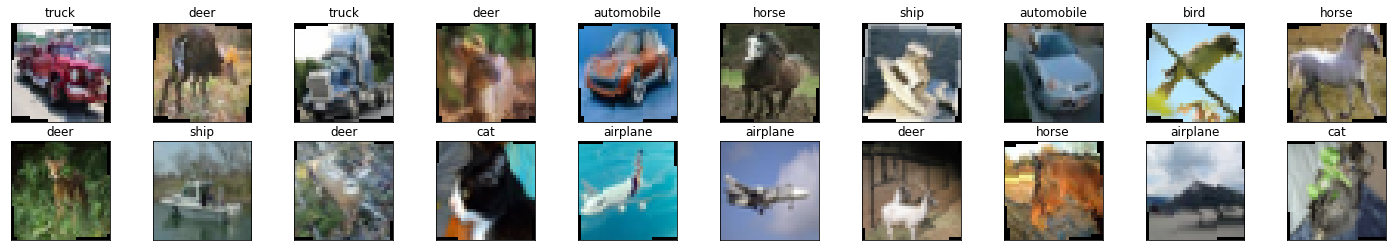

In [45]:
# Plot de um batch de imagens de treino
# Área de plotagem
fig=plt.figure(figsize=(25,4))

# loop e print
for idx in np.arange(20):

    # Cria os subplots
    ax =fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])

    # Desfaz a normalização
    # imagens[idx]
    imshow(images[idx])

    # Coloca o título
    ax.set_title(classes[labels[idx]])